# Contrastive Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

import wandb
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models

import timm
from tqdm import tqdm
import logging
from rich.logging import RichHandler
from typing import Dict, List, Tuple

import os
import time
import copy
import joblib
from collections import defaultdict
import gc
import random
from glob import glob

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

%load_ext watermark
%watermark -v -p torch,matplotlib,numpy,seaborn,pandas

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.9.0

torch     : 2.0.0
matplotlib: 3.6.3
numpy     : 1.23.5
seaborn   : 0.12.2
pandas    : 1.5.3



# Config

In [2]:
class cfg:
    seed          = 42
    project_name  = 'frs-kavach'
    exp_name      = 'contrastive-frs'
    base_model    = 'resnext50_32x4d'
    train_bs      = 8
    valid_bs      = train_bs
    image_size    = [112, 112]
    comment       = f'basemodel-{base_model}|img_size-{image_size[0]}x{image_size[1]}'
    epochs        = 50
    
    optimizer     = 'Adam'
    learning_rate = 3e-4
    rho           = 0.9
    eps           = 1e-6
    lr_decay      = 0
    betas         = (0.9, 0.999)
    momentum      = 0
    alpha         = 0.99
    
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    weight_decay  = 1e-6
    
    n_accumulate  = max(1, 32//train_bs)
    num_folds     = 5
    num_classes   = None

    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    iteration_num = 1

    train_path    = '../../artifacts/archive/'

# Model

## Encoder

In [3]:
import torch.nn as nn
from torchvision import models
def get_backbone(backbone: str):
    if backbone == 'convnext_base':
        encoder = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'convnext_large':
        encoder = models.convnext_large(weights=models.ConvNeXt_Large_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'efficientnet_b1':
        encoder = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'efficientnet_b3':
        encoder = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'efficientnet_b5':
        encoder = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'efficientnet_b7':
        encoder = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'resnet50':
        encoder = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'resnet101':
        encoder = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'resnext50_32x4d':
        encoder = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'resnext101_64x4d':
        encoder = models.resnext101_64x4d(weights=models.ResNeXt101_64X4D_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'swin_b':
        encoder = models.swin_b(weights=models.Swin_B_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'vit_b_16':
        encoder = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    elif backbone == 'vit_b_32':
        encoder = models.vit_b_32(weights=models.ViT_B_32_Weights.DEFAULT)
        encoder = nn.Sequential(*(list(encoder.children())[:-1]))
        return encoder
    else:
        raise NotImplementedError

## Projection

In [4]:
class Projection(nn.Module):
    def __init__(self, hidden_size: int, hidden_dim: int) -> None:
        super(Projection, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_size, 4*hidden_size), 
            nn.ReLU(),
            nn.Linear(4*hidden_size, hidden_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection(x)

# Loss Function

## Base Loss

In [5]:
class BaseSimilarityLoss(nn.Module):
    """Provides the base class for the loss functions for contrastive learning."""
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)


    @staticmethod
    def euclidean_dist(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        return (x1 - x2).pow(2).sum(1)

    @staticmethod
    def manhattan_dist(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        return torch.abs(x1 - x2).sum(1)
    
    @staticmethod
    def cosine_dist(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        return 1 - F.cosine_similarity(x1, x2)

    def forward(self):
        raise NotImplementedError

## Triplet Loss

In [6]:
class TripletLoss(BaseSimilarityLoss):
    '''This implements the Triplet Loss'''
    def __init__(self, margin: float = 1.0, *args, **kwargs) -> None:
        '''
        Args:
        - margin: float 
            - the margin for the Triplet Loss
        '''
        super().__init__(*args, **kwargs)
        self.margin = margin
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        '''
        Args: 
        * anchor: torch.Tensor
        * positive: torch.Tensor
        * negative: torch.Tensor
        Return:
        * loss: torch.Tensor
            - The TripletLoss distance between the anchor, positive, negative
        '''
        positive_dist = self.cosine_dist(anchor, positive)
        negative_dist = self.cosine_dist(anchor, negative)
        return torch.relu(positive_dist - negative_dist + self.margin).mean()

## NT-Xent Loss

$$\mathcal{l}_{i, j} = -\log\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}1_{k\neq1}\text{sim}(z_i, z_k)/\tau)}$$

In [7]:
class NT_Xent(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

# Data

In [8]:
data = np.load('../../artifacts/olivetti/olivetti_faces.npy')
data.shape

(400, 64, 64)

In [9]:
target = np.load('../../artifacts/olivetti/olivetti_faces_target.npy')
target.shape

(400,)

In [10]:
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

In [11]:
images_dataset, labels_dataset = generate_image_pairs(data, target)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [12]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

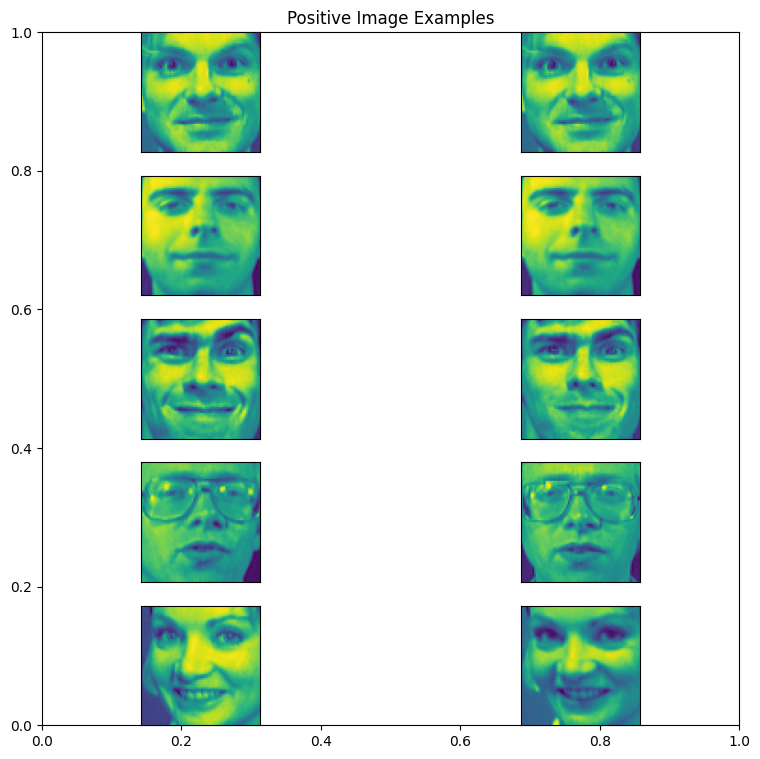

In [13]:
n = 3
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

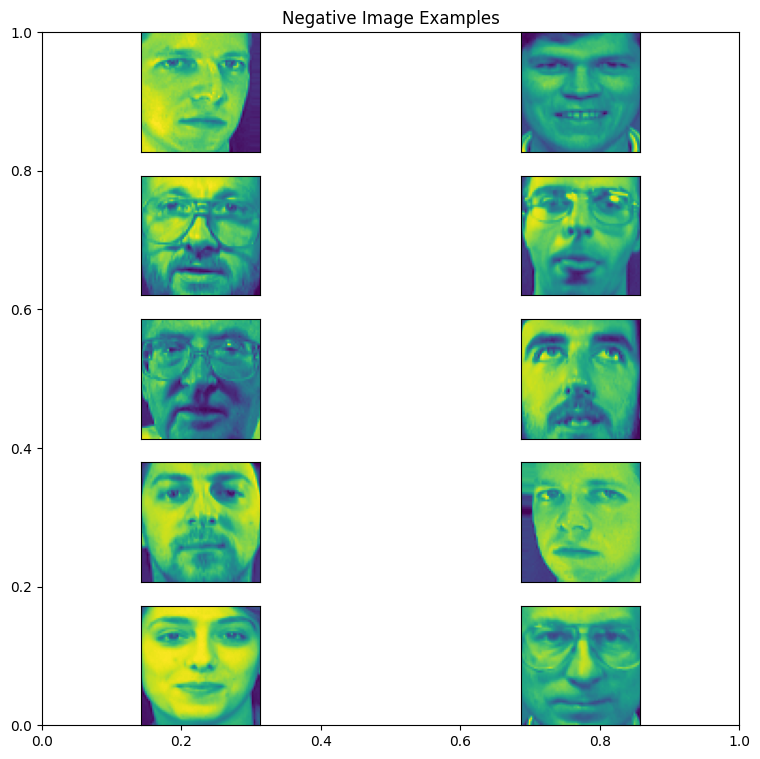

In [14]:
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

In [15]:
images_dataset.shape, labels_dataset.shape

((800, 2, 64, 64), (800,))

In [16]:
images_dataset[0].shape

(2, 64, 64)

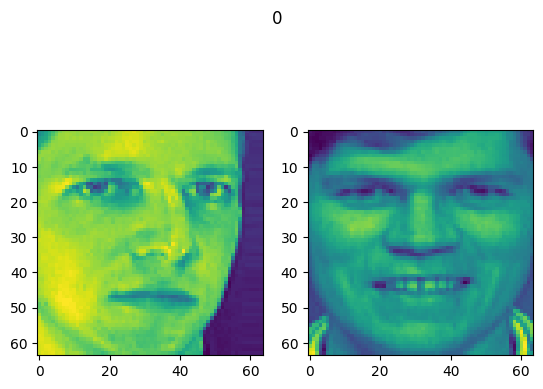

In [17]:
plt.subplot(121)
plt.imshow(images_dataset[0][0])
plt.subplot(122)
plt.imshow(images_dataset[0][1])
plt.suptitle(labels_dataset[0])
plt.show()

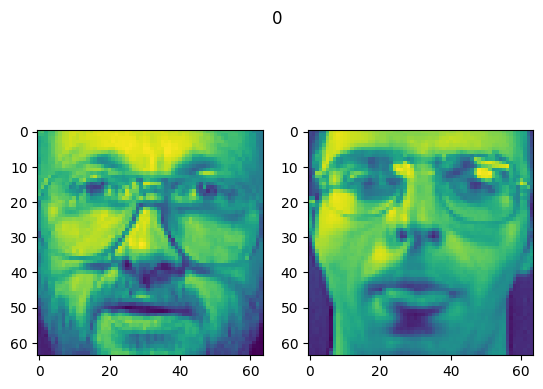

In [18]:
plt.subplot(121)
plt.imshow(images_dataset[1][0])
plt.subplot(122)
plt.imshow(images_dataset[1][1])
plt.suptitle(labels_dataset[1])
plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images_dataset, labels_dataset)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600, 2, 64, 64), (200, 2, 64, 64), (600,), (200,))

In [20]:
encoder = get_backbone(cfg.base_model)

In [21]:
X_train[0][0].shape

(64, 64)

In [22]:
%%time
y = encoder.forward(torch.tensor(np.stack([X_train[0][0]]*3)).unsqueeze(0))
y.shape

CPU times: user 39.5 ms, sys: 73.9 ms, total: 113 ms
Wall time: 49.2 ms


torch.Size([1, 2048, 1, 1])

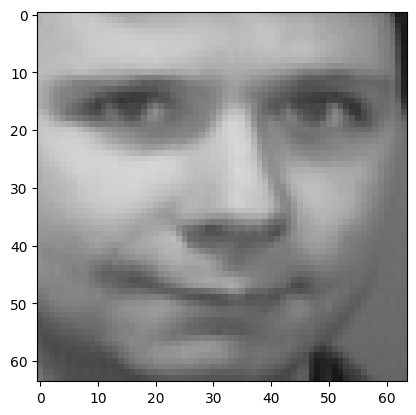

In [23]:
plt.imshow(torch.Tensor(np.stack([X_train[0][0]]*3)).permute(1, 2, 0));

In [24]:
class OlivettiDataset(Dataset):
    def __init__(self, X: np.array, y: np.array) -> None:
        super(OlivettiDataset, self).__init__()
        self.X = X
        self.y = y
    
    def __len__(self) -> int:
        return self.X.shape[0]
    
    def __getitem__(self, ix: int) -> Dict[str, torch.Tensor]:
        x1 = self.X[ix][0]
        x2 = self.X[ix][1]
        y = self.y[ix]
        
        x1 = torch.tensor(np.stack([x1]*3)).to(torch.float32)
        x2 = torch.tensor(np.stack([x2]*3)).to(torch.float32)
        y = torch.LongTensor([y])

        return {
            'x1': x1,
            'x2': x2,
            'y': y
        }

In [25]:
dataset = OlivettiDataset(X_train, y_train)

In [26]:
batch = dataset[0]

In [27]:
{k: v.shape for k, v in batch.items()}

{'x1': torch.Size([3, 64, 64]),
 'x2': torch.Size([3, 64, 64]),
 'y': torch.Size([1])}

In [28]:
traindataset = OlivettiDataset(X_train, y_train)
validdataset = OlivettiDataset(X_test, y_test)

trainloader = DataLoader(traindataset, batch_size=cfg.train_bs, shuffle=True)
validloader = DataLoader(validdataset, batch_size=cfg.valid_bs, drop_last=True)

In [29]:
batch = next(iter(trainloader))
{k: v.shape for k, v in batch.items()}

{'x1': torch.Size([8, 3, 64, 64]),
 'x2': torch.Size([8, 3, 64, 64]),
 'y': torch.Size([8, 1])}

# Model

In [30]:
class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()
        self.encoder = get_backbone(backbone=cfg.base_model)
        self.encoder.eval()
        self.projection = Projection(hidden_size=2*1024, hidden_dim=768)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            h = self.encoder(x)
        h = h.view(h.shape[0], -1)
        return self.projection(h)

In [31]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    criterion = NT_Xent(batch_size=cfg.train_bs, temperature=0.7)
    model.train()
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, batch in pbar:
        x1, x2, y = batch['x1'].to(device), batch['x2'].to(device), batch['y'].to(device)
        
        batch_size = x1.shape[0]
        z1 = model(x1)
        z2 = model(x2)
        
        loss = criterion(z1, z2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}')
        gc.collect()
    
    return epoch_loss

In [32]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    criterion = NT_Xent(batch_size=cfg.valid_bs, temperature=0.7)
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, batch in pbar:
        x1, x2, y = batch['x1'].to(device), batch['x2'].to(device), batch['y'].to(device)
        
        batch_size = x1.shape[0]
        
        z1 = model(x1)
        z2 = model(x2)
        
        loss = criterion(z1, z2)
            
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}')
        gc.collect()
    
    return epoch_loss

In [33]:
model = SimCLRModel()
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, 
                       weight_decay=cfg.weight_decay)
scheduler = None
device = torch.device("cuda" if torch.has_cuda else "cpu")

In [34]:
from copy import deepcopy

In [35]:
best_loss = np.infty
best_model_wts = deepcopy(model.state_dict())

for epoch in range(cfg.epochs):
    print(f'#'*15)
    print(f'### EPOCH {epoch} ')
    print(f'#'*15)
    
    train_loss = train_one_epoch(model, optimizer, scheduler, trainloader, device, epoch=epoch)
    valid_loss = valid_one_epoch(model, validloader, device, epoch=epoch)
    
    print(f'train_loss: {train_loss:.5f} | valid_loss: {valid_loss:.5f}')
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model_wts = deepcopy(model.state_dict())
        torch.save(best_model_wts, f'../../artifacts/model-weights/face-rec.pth')

###############
### EPOCH 0 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.82it/s, train_loss=2.6567]


train_loss: 2.62611 | valid_loss: 2.65674
###############
### EPOCH 1 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s, train_loss=2.6462]


train_loss: 2.56291 | valid_loss: 2.64621
###############
### EPOCH 2 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.72it/s, train_loss=2.6667]


train_loss: 2.56429 | valid_loss: 2.66666
###############
### EPOCH 3 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.69it/s, train_loss=2.6476]


train_loss: 2.49836 | valid_loss: 2.64759
###############
### EPOCH 4 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.66it/s, train_loss=2.6523]


train_loss: 2.45839 | valid_loss: 2.65226
###############
### EPOCH 5 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.93it/s, train_loss=2.6537]


train_loss: 2.42149 | valid_loss: 2.65368
###############
### EPOCH 6 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.82it/s, train_loss=2.6736]


train_loss: 2.44869 | valid_loss: 2.67361
###############
### EPOCH 7 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.70it/s, train_loss=2.6851]


train_loss: 2.41404 | valid_loss: 2.68515
###############
### EPOCH 8 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s, train_loss=2.6918]


train_loss: 2.37660 | valid_loss: 2.69177
###############
### EPOCH 9 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.74it/s, train_loss=2.6044]


train_loss: 2.34529 | valid_loss: 2.60443
###############
### EPOCH 10 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.92it/s, train_loss=2.6536]


train_loss: 2.35475 | valid_loss: 2.65364
###############
### EPOCH 11 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.76it/s, train_loss=2.6669]


train_loss: 2.34406 | valid_loss: 2.66688
###############
### EPOCH 12 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s, train_loss=2.5964]


train_loss: 2.30467 | valid_loss: 2.59644
###############
### EPOCH 13 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.90it/s, train_loss=2.5768]


train_loss: 2.30822 | valid_loss: 2.57684
###############
### EPOCH 14 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [11:51<00:00, 28.48s/it, train_loss=2.5626]


train_loss: 2.31258 | valid_loss: 2.56261
###############
### EPOCH 15 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.61it/s, train_loss=2.6245]


train_loss: 2.32194 | valid_loss: 2.62454
###############
### EPOCH 16 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.64it/s, train_loss=2.5929]


train_loss: 2.29661 | valid_loss: 2.59286
###############
### EPOCH 17 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.64it/s, train_loss=2.5741]


train_loss: 2.29890 | valid_loss: 2.57405
###############
### EPOCH 18 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.68it/s, train_loss=2.5286]


train_loss: 2.27591 | valid_loss: 2.52858
###############
### EPOCH 19 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.66it/s, train_loss=2.6016]


train_loss: 2.28710 | valid_loss: 2.60158
###############
### EPOCH 20 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.73it/s, train_loss=2.5637]


train_loss: 2.25955 | valid_loss: 2.56368
###############
### EPOCH 21 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.64it/s, train_loss=2.5750]


train_loss: 2.23653 | valid_loss: 2.57498
###############
### EPOCH 22 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.67it/s, train_loss=2.5522]


train_loss: 2.26314 | valid_loss: 2.55223
###############
### EPOCH 23 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.66it/s, train_loss=2.5315]


train_loss: 2.25358 | valid_loss: 2.53153
###############
### EPOCH 24 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.83it/s, train_loss=2.5328]


train_loss: 2.24377 | valid_loss: 2.53277
###############
### EPOCH 25 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [10:49<00:00, 25.98s/it, train_loss=2.5252]


train_loss: 2.21823 | valid_loss: 2.52516
###############
### EPOCH 26 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.61it/s, train_loss=2.5564]


train_loss: 2.23644 | valid_loss: 2.55639
###############
### EPOCH 27 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.98it/s, train_loss=2.5467]


train_loss: 2.21484 | valid_loss: 2.54667
###############
### EPOCH 28 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.60it/s, train_loss=2.5515]


train_loss: 2.21136 | valid_loss: 2.55148
###############
### EPOCH 29 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.61it/s, train_loss=2.5587]


train_loss: 2.19637 | valid_loss: 2.55870
###############
### EPOCH 30 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [23:11<00:00, 55.67s/it, train_loss=2.5619]


train_loss: 2.18857 | valid_loss: 2.56191
###############
### EPOCH 31 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.77it/s, train_loss=2.5929]


train_loss: 2.21127 | valid_loss: 2.59287
###############
### EPOCH 32 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s, train_loss=2.5487]


train_loss: 2.20483 | valid_loss: 2.54871
###############
### EPOCH 33 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s, train_loss=2.5393]


train_loss: 2.19704 | valid_loss: 2.53929
###############
### EPOCH 34 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.50it/s, train_loss=2.5313]


train_loss: 2.17156 | valid_loss: 2.53131
###############
### EPOCH 35 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.86it/s, train_loss=2.5571]


train_loss: 2.19000 | valid_loss: 2.55712
###############
### EPOCH 36 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.71it/s, train_loss=2.5838]


train_loss: 2.17397 | valid_loss: 2.58378
###############
### EPOCH 37 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.63it/s, train_loss=2.5384]


train_loss: 2.17510 | valid_loss: 2.53835
###############
### EPOCH 38 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.63it/s, train_loss=2.5617]


train_loss: 2.17548 | valid_loss: 2.56174
###############
### EPOCH 39 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:43<00:00, 11.32s/it, train_loss=2.5645]


train_loss: 2.15798 | valid_loss: 2.56454
###############
### EPOCH 40 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.65it/s, train_loss=2.5378]


train_loss: 2.17874 | valid_loss: 2.53779
###############
### EPOCH 41 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.91it/s, train_loss=2.5115]


train_loss: 2.14190 | valid_loss: 2.51146
###############
### EPOCH 42 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.59it/s, train_loss=2.4928]


train_loss: 2.13662 | valid_loss: 2.49280
###############
### EPOCH 43 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.82it/s, train_loss=2.5328]


train_loss: 2.11344 | valid_loss: 2.53280
###############
### EPOCH 44 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s, train_loss=2.5206]


train_loss: 2.13714 | valid_loss: 2.52058
###############
### EPOCH 45 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.52it/s, train_loss=2.5162]


train_loss: 2.11327 | valid_loss: 2.51623
###############
### EPOCH 46 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:58<00:00,  9.53s/it, train_loss=2.5594]


train_loss: 2.12193 | valid_loss: 2.55936
###############
### EPOCH 47 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.78it/s, train_loss=2.5943]


train_loss: 2.10635 | valid_loss: 2.59425
###############
### EPOCH 48 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.73it/s, train_loss=2.5241]


train_loss: 2.11633 | valid_loss: 2.52414
###############
### EPOCH 49 
###############


Valid : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.77it/s, train_loss=2.5427]

train_loss: 2.11636 | valid_loss: 2.54272
